# Week 5 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. This week, we ask you to articulate what your sample represents in context of your final project, and draw upon methods we have developed over the last three weeks to draw reasonable and representative samples. 

This week we also pivot from our recent work on unsupervized machine learning approaches to explore how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in the two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

## ***What?*** 
<200 words

For our final project, our group (Hyunku Kwon, Xingyun Wu, Oscar Stuhler) scraped a text corpus of tv show transcripts from http://tvmegasite.net. Our corpus contains more than 30.000 full transcripts of episodes from 12 different tv shows, some of which have been running and were continuously transcribed for more than 20 years. The tv shows fall broadly into the genre of soap operas. The size of this corpus might make it necessary that we work with a subset of the data. Our transcripts maintain a stable format which allows us to subset our data into individual speaking turns, nested in scenes, nested in episodes. The structure of the transcripts allows us to unambiguously allocate each speaking turn to a speaker - usually a regular character from the show. From these names, we will then infer the gender of the respective character. We will probably be doing this by hand coding the names based on a wiki, also provided on the website.

On a side note, this is (probably) the original data that was used by Mark Davies (BYU/Google books) to construct his "Corpus of American Soap Operas." However, unfortunately, he does not make that corpus available.

## ***Why?***
<200 words

Our main interest lies in the question how gender relations are represented in these tv shows. We see the fact that our data stems from scripted shows as a strength rather than a disadvantage. Real life is fuzzy and private dialogues are rarely transcribed. While our data do not allow us to draw direct inference about the 'real world,' we hope to be able to illuminate gender stereotypes much more clearly with our data than we could with 'real' data.

Our analytical interest can be divided into three branches.

1: Interaction

We are interested in how men and women interact differently with each other and among themselves. Exemplary questions are: Are there discourse markers that appear more often when men address women than when they address other men? Do women ask more questions in interactions with men than interactions with women?

2: Thematic

We are also interested in the thematic dimension of gender. Specifically, we would like to investigate what topics women talk about when they are among themselves within a scene and how these might differ from the topics men talk about among themselves. Another question would be how women talk about men when they are not present and how men talk about women when they are not present.

3: Temporal

Our earliest transcripts date back to 1998. We thus have sufficient data to trace how the above aspects changed over time. Can we see that women talk about different issues in 2018 than in 1998?

## ***How?***
<400 words

The methods we will be using for our project accord to the respective analytical interest.

1: Interaction

In order to analyze features of interaction, we have a twofold strategy. The first one is purely data driven and uses classification methods as discussed in week 6. For example, we will subset all statements made by men in all scenes into two classes: statements that were preceded by a statement of a woman and statements that were preceded by another man. We then run a Naive Bayes Classifier to see whether there are any terms that distinguish these two sets. Doing this will also involve trial and error - for example restricting us to the first 5 sentences of a turn - and identifying significant collocations. Ideally, we would find that men frequently open their turns with mansplaining markers like "That's right, BUT.."

To complement our data-driven approach, we will also be coding theoretically derived discourse markers with regular expressions to see who uses them and possibly how this differs by scene. Here, we want to follow the footsteps of McFarland et al. (2013) and code features like hedges (I guess, probably, sorta, kinda, etc.), self-markers (I, me, my, mine VS you, your, yours) or questions. Time constraints will determine how deep we can go into this.

2: Thematic

To analyze thematic differences we will rely on a range of approaches. One thing we want to do is run a topic model over the whole corpus where the full scenes are the documents. We will then create a categorical variable that distinguishes scenes where only men are present, only women are present, or people of both genders are present. We will then investigate whether there are topics that are overrepresented in conversations between women or between men.

Another question posed above is how men talk about women versus how women talk about men. In order to extract such statements, we will use a list of the names of the characters of the show, as well as markers like "he" or "she." We will then use a POS tagger to filter out the adjectives used in the respective statements and compare: how do men describe women and how do women describe men?

2: Temporal

In principle, all of the above analyses can be put into a temporal framework but for some this might be more interesting than for others. Do the topics women talk about in 2018 differ from those in 1999?

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

As already noted above, we are interested in how genders are represented in American tv culture. Our transcript corpus is large but obviously restricted in its external validity. Soap operas are a particular medium and probably a rather conservative one with strong gender stereotypes. However, we hope that precisely this will allow us to a) actually get some results b) sharpen our methodological tools which we could then apply to an extended corpus of - for example - film transcripts. Furthermore, we chose this data because the transcripts are extraordinarily clean and thus lend themselves to analyzing the questions we are interested in. We did look into databases with film transcripts but it appears that there are none that are sufficiently standardized so that we could use them for this project. Do you know of any good sources here? The ultimate question remains, if we are not able to go beyond the material we currently have, is our data interesting enough for an article in, say, Poetics?

## ***Which (words)?***
<300 words

I'm afraid I genuinely don't understand what you mean by this question or how I could answer it well with regard to our project. If you feel that our project is unclearly formulated, I would be really glad to visit one of your office hours.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, demonstrate three approaches drawn from any of the last three weeks to create subsamples of your corpus (e.g., for crowd-sourced subcoding like we'll be doing this week). Methods of subsampling include (a) corpus linguistic approaches drawing on word presence or co-presence, conditional frequencies, weighted words (e.g., tf.idf), KL or JS divergences, etc.; (b) hierarchical or flat clustering approaches; (c) topic modeling; or (d) word-embedding. (<200 words).

In [2]:
#In what follows, we demonstrate a few approaches listed above on our data. We have not cleaned the data to the degree
#that we should have and thus this will be some exemplary code that is rather detached from how we will actually
#subset the data. Since we're three people working on the data this was a collaborative effort but, frankly, 
#Xingyung should be credited with having written most of this. Because running the code on all episodes 
#of All My Children(especially topic modeling), I only use the episodes of three years here: 1998, 2004, and 2013.

#First we read in the data and create a pandas df
d = {'filename':[], 'text':[]}
dir_amc = '/Users/oscar/Dropbox/amc'
year_lst = os.listdir(dir_amc) [1:]
for i in range(len(year_lst)):
    episodes = os.listdir(dir_amc+'/'+year_lst[i])
    for j in range(len(episodes)):
        file_name = year_lst[i]+'/'+episodes[j]
        temp_text = ''
        with open(dir_amc+'/'+file_name) as f:
            for line in f:
                temp_text += line.replace('\n', ' ')
        d['filename'].append(file_name)
        d['text'].append(temp_text)

amcDF = pandas.DataFrame(d)
amcDF[0:10]

,filename,text
0,1998/02-14-84.txt,All My Children Transcript Tuesday 2/14/84 ...
1,1998/03-04-93.txt,All My Children Transcript Thursday 3/4/93 ...
2,1998/06-04-98.txt,All My Children Transcript Thursday 6/4/98 Pro...
3,1998/07-07-98.txt,All My Children Transcript Tuesday 7/7/98 Prov...
4,1998/09-03-80.txt,All My Children Transcript Wednesday 9/3/80 ...
5,2004/01-02-04.txt,All My Children Transcript Friday 1/2/04 By ...
6,2004/01-05-04.txt,All My Children Transcript Monday 1/5/04 By...
7,2004/01-06-04.txt,All My Children Transcript Tuesday 1/6/04 By ...
8,2004/01-07-04.txt,All My Children Transcript Wednesday 1/7/04 By...
9,2004/01-08-04.txt,All My Children Transcript Thursday 1/8/04 B...


In [3]:
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

#Then, we do some flat clustering. To do so, the documents are turned into raw word count vectors:
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
amcgroupsVects = ngCountVectorizer.fit_transform(amcDF['text'])
ngCountVectorizer.vocabulary_.get('vector')

#Now use tf-idf
amcgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(amcgroupsVects)
amcgroupsTF = amcgroupsTFTransformer.transform(amcgroupsVects)
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words='english')
amcgroupsTFVects = ngTFVectorizer.fit_transform(amcDF['text'])

In [4]:
#Part of the fun of this project is to randomly stumble across hilarious strings of text and imagine the scene; and 
#I see no particular reason to withold that from you:

print("Man: Is that him? Is that the animal who tried to kill Marcus? "
      "You are going to  pay for what you did to my son!")

Man: Is that him? Is that the animal who tried to kill Marcus? You are going to  pay for what you did to my son!


In [5]:
#Run kmeans with 10 clusters
km = sklearn.cluster.KMeans(n_clusters=10, init='k-means++')
km.fit(amcgroupsTFVects)
amcDF['kmeans_predictions'] = km.labels_

In [6]:
#Check top words for each center
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(9):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')
    
#Because we did not prepare our data yet, these clusters are mostly comprised of
#names. This is not really helpful but, again, we just demonstrate the method here.
#We see names here because of course any transcripts will contain many of them and probably
#characters came onto and dropped out of the show. The data here is based on the shows 4 weekly
#episodes from 1998 to 2013.

Top terms per cluster:
Cluster 0:
 danielle
 reggie
 babe
 know
 just
 ryan
 bianca
 krystal
 don
 derek


Cluster 1:
 babe
 bianca
 kendall
 know
 just
 ryan
 tad
 greenlee
 krystal
 don


Cluster 2:
 erica
 jack
 kendall
 ryan
 bianca
 know
 just
 greenlee
 don
 going


Cluster 3:
 cara
 jr
 lea
 dimitri
 okay
 aj
 jesse
 gonna
 pete
 brooke


Cluster 4:
 jesse
 pete
 aj
 angie
 celia
 okay
 cassandra
 jr
 gonna
 miranda


Cluster 5:
 ethan
 ryan
 zach
 greenlee
 know
 kendall
 just
 jonathan
 babe
 don


Cluster 6:
 greenlee
 ryan
 bobby
 know
 kendall
 anita
 just
 edmund
 bianca
 maria


Cluster 7:
 lily
 know
 just
 bianca
 erica
 jack
 don
 babe
 jamie
 reggie


Cluster 8:
 alan
 fred
 kendall
 greenlee
 livia
 ryan
 jack
 mia
 just
 aidan




In [7]:
import nltk

#Next we do some topic modeling. In our final project, we will ron topic models over scenes nested within
#episodes but here we just run it over the episodes, which doesn't make a lot of sense of course.
#First we tokenize the text
amcDF['tokenized_text'] = amcDF['text'].apply(lambda x: nltk.word_tokenize(x))

In [8]:
#And use standardize preparing methods we used earlier:

def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)
        
    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)
    
    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

from nltk.corpus import stopwords
stop_words_nltk = stopwords.words('english')
amcDF['normalized_tokens'] = amcDF['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = nltk.stem.porter.PorterStemmer()))

# Drop the tokenized and normalized words that are not in the vocabulary
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]
amcDF['reduced_tokens'] = amcDF['normalized_tokens'].apply(lambda x: dropMissing(x, ngCountVectorizer.vocabulary_.keys()))

In [9]:
#Run the topic model.
import gensim
amc_d = gensim.corpora.Dictionary(amcDF['reduced_tokens'])
amc_corpus = [amc_d.doc2bow(text) for text in amcDF['reduced_tokens']]
gensim.corpora.MmCorpus.serialize('amc.mm', amc_corpus)
amc_senmm = gensim.corpora.MmCorpus('amc.mm')

amc_senlda = gensim.models.ldamodel.LdaModel(corpus=amc_senmm, id2word=amc_d, num_topics=10, alpha='auto', eta='auto')

amc_ldaDF = pandas.DataFrame({
        'name' : amcDF['filename'],
        'topics' : [amc_senlda[amc_d.doc2bow(l)] for l in amcDF['reduced_tokens']]
    })

In [10]:
#Here is the topic model output:
amc_ldaDF[1:5]

,name,topics
1,1998/03-04-93.txt,"[(4, 0.6968672), (6, 0.10960863), (8, 0.185009..."
2,1998/06-04-98.txt,"[(8, 0.9838972), (9, 0.013390191)]"
3,1998/07-07-98.txt,"[(1, 0.075784884), (8, 0.9111557)]"
4,1998/09-03-80.txt,"[(1, 0.998174)]"


In [11]:
#Dict to temporally hold the probabilities
amc_topicsProbDict = {i : [0] * len(amc_ldaDF) for i in range(amc_senlda.num_topics)}
#Load them into the dict
for index, topicTuples in enumerate(amc_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        amc_topicsProbDict[topicNum][index] = prob
#Update the DataFrame
for topicNum in range(amc_senlda.num_topics):
    amc_ldaDF['topic_{}'.format(topicNum)] = amc_topicsProbDict[topicNum]

amc_ldaDFV = amc_ldaDF[:10][['topic_%d' %x for x in range(10)]]
amc_ldaDFVisN = amc_ldaDF[:10][['name']]
amc_ldaDFVis = amc_ldaDFV.as_matrix(columns=None)
amc_ldaDFVisNames = amc_ldaDFVisN.as_matrix(columns=None)
print("Here is some examplary topic model output")
amc_ldaDFV[1:5]

Here is some examplary topic model output


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,0.0,0.000000,0.0,0.0,0.696867,0.0,0.109609,0.0,0.185010,0.00000
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.983897,0.01339
3,0.0,0.075785,0.0,0.0,0.000000,0.0,0.000000,0.0,0.911156,0.00000
4,0.0,0.998174,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000


In [12]:
#Now finally, c), we employ a word embedding approach and run a word2vec model.
amcDF['tokenized_sents'] = amcDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
amcDF['normalized_sents'] = amcDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = None) for s in x])

# word2vec
amcW2V = gensim.models.word2vec.Word2Vec(amcDF['normalized_sents'].sum())
amcW2V.most_similar('home')
amcW2V.most_similar('work')




[('pay', 0.825782299041748),
 ('figure', 0.8049071431159973),
 ('mess', 0.8039853572845459),
 ('past', 0.7993651032447815),
 ('point', 0.7833766937255859),
 ('start', 0.7804585695266724),
 ('sooner', 0.7722327709197998),
 ('worse', 0.7622306942939758),
 ('harder', 0.7618327140808105),
 ('sleep', 0.7552904486656189)]

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

In [13]:
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [14]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [15]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [16]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [17]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


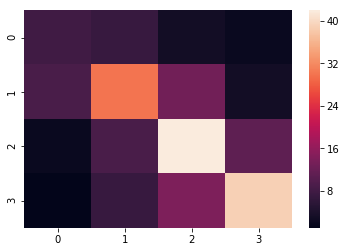

In [18]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [19]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [20]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [21]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [22]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [23]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


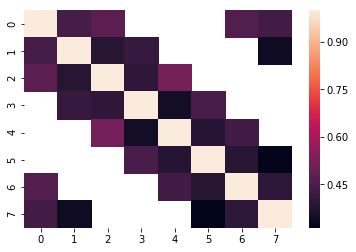

In [24]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [25]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [26]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [27]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

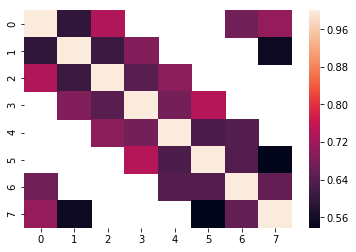

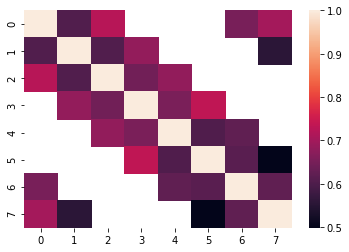

In [28]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [29]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <span style="color:red">*Excercise 2*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides on this week's Canvas page.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [30]:
#For this weeks homework, I conducted two surveys on MTurk. For the first, I extracted the most frequent 20 nouns 
#in our soap opera corpus (not taking into account character names or places mentioned in the series). I then created
#a Qualtrics survey where each of 10 independent coder had to code every of the 20 words on a 10-point scale
#from male to female. The instructions given read as follows:

#"There are things that men talk about more often than women, and there are things that 
#women talk about more often than men. In the following slides you will be presented a series of words. 
#Who do you think talks about this thing or issue? Mostly men, mostly women, or something in between?"

#The 10-point scales used had two verbal anchors: 1 "mostly men" and 10 "mostly women."

#First I load the whole survey into a pandas df. I prepared this file prehand in Excel, keeping only the relevant
#information.
short_survey = pandas.read_csv('../data/survey/Short_survey_modified.csv', index_col=0, delimiter = ";")

#I also asked the survey participants for their gender to subset the data. This way we can see whether there are 
#systematic differences in gender perception and whether the measures are more coherent within gender than overall.
#My survey was taken by 6 women and 4 men.
#Just from looking at the dataframe, it indeed seems as though there are systematic gender differences.
#Of course I'm drawing inference based on very few cases here but if you look at the last 
#column - the word "babe" - it appears that men think that it is mostly them who talk about babes while some
#women tend to think that they are the ones who talk about babes. Could it be that we all talk about babes all
#the time but just haven't found out yet? To be fair, it also appears that some test takers mistook the question as
#"what gender do you associate with these word?" as opposed to "who talks about these things?" Looking back,
#I probably should have worded my question more carefully, but this was only for test purposes.

short_survey_male = short_survey[short_survey.Gender == "Male"]
short_survey_female = short_survey[short_survey.Gender == "Female"]
short_survey

,life,love,night,home,men,wife,tv,baby,work,family,honey,god,father,promise,trust,hell,heart,mom,babe,Gender
time,,,,,,,,,,,,,,,,,,,,
6,7,8,4,5,1,10,8,5,9,8,7,8,1,8,7,6,8,8,8,Female
7,6,8,7,9,3,9,3,2,2,8,2,9,6,8,8,2,7,8,1,Male
6,6,8,6,8,8,3,5,9,5,6,7,5,6,6,8,5,6,5,6,Female
3,6,10,5,8,10,1,6,1,2,5,7,5,5,8,8,6,10,5,1,Male
4,5,9,5,8,5,2,6,8,5,5,8,5,4,7,8,4,9,8,3,Female
5,8,8,3,9,8,3,5,9,4,7,8,6,5,7,8,7,9,9,4,Female
9,9,10,9,8,10,1,8,9,5,10,10,8,8,10,9,6,10,10,1,Female
4,5,7,4,8,8,2,6,9,4,8,5,5,5,7,8,5,9,5,2,Male
7,5,7,5,6,6,1,5,8,6,6,7,3,6,8,8,3,8,8,2,Male


In [31]:
#Here in convert the pandas to arrays, transpose them, and finally turn them into a AnnotationsContainer.
short_survey_array = np.transpose(pandas.DataFrame.as_matrix(short_survey.iloc[0:10,0:19]))
short_survey_men_array = np.transpose(pandas.DataFrame.as_matrix(short_survey_male.iloc[0:10,0:19]))
short_survey_women_array = np.transpose(pandas.DataFrame.as_matrix(short_survey_female.iloc[0:10,0:19]))
anno_short = AnnotationsContainer.from_array(short_survey_array)
anno_short_men = AnnotationsContainer.from_array(short_survey_men_array)
anno_short_women = AnnotationsContainer.from_array(short_survey_women_array)

In [32]:
#It appears that "8" that scales towards the women pole was the most used label.
pyanno.measures.agreement.labels_frequency(anno_short.annotations, 6)

array([0.04736842, 0.05263158, 0.04736842, 0.04736842, 0.16315789,
       0.13157895, 0.1       , 0.25789474, 0.09473684, 0.05789474])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 2. 2. 0. 0. 0. 0.]
 [1. 0. 0. 0. 3. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 0. 2.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


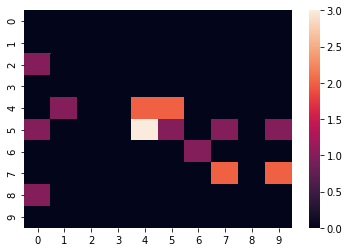

In [33]:
#Here I crate a confusion matrix to compare coders. Generally we see that the count of exact agreement is fairly
#low. But that is mostly an artifact of having a very nuanced scale. 
f = pyanno.measures.agreement.confusion_matrix(anno_short.annotations[:,2], anno_short.annotations[:,3], nclasses = 10)
print(f)
ac = seaborn.heatmap(f)
plt.show()

In [34]:
#Now let's turn to some statistical measures. Here is Scott's pi between third and fourth two coders.
#..and it's pretty low. But again, the scale is very naunces. Although of course it might also
#indicate that the scale is too nuanced.
print("Scott's pi:")
print(scotts_pi(anno_short.annotations[:,2], anno_short.annotations[:,3]))

Scott's pi:
0.15555555555555553


In [35]:
#Here is Fleiss' Kappa for the different three corpuses.
#We see that agreement among men seems to be higher than among women.
print("Fleiss Kappa (all):")
print(fleiss_kappa(anno_short.annotations[::]))
print("Fleiss Kappa (men):")
print(fleiss_kappa(anno_short_men.annotations[::]))
print("Fleiss Kappa (women):")
print(fleiss_kappa(anno_short_women.annotations[::]))

Fleiss Kappa (all):
0.06184960312334035
Fleiss Kappa (men):
0.10432569974554706
Fleiss Kappa (women):
0.006535947712418336


In [36]:
#Krippendorff's α takes into account that our scale is ordinal and the labels are not actually
#categorically different. This seems to be a more appropriate measure for my data.
#Again we find that agreement among men is higher than among women. However, agreement generally
#seems to be rather low. This should make us - that is me - critical of how I posed the question.
print("Krippendorff's  α (all):")
print(krippendorffs_alpha(anno_short.annotations[::]))
print("Krippendorff's  α (men):")
print(krippendorffs_alpha(anno_short_men.annotations[::]))
print("Krippendorff's  α (women):")
print(krippendorffs_alpha(anno_short_women.annotations[::]))

Krippendorff's  α (all):
0.3368334119867863
Krippendorff's  α (men):
0.37782648503176763
Krippendorff's  α (women):
0.29690147019680924


Average  Cohen's κ for all pairs:
0.26005279536317805
Average  Cohen's κ for men:
0.3061145326175947
Average  Cohen's κ for women:
0.21283322323709755
Heatmap of cohens κ between men


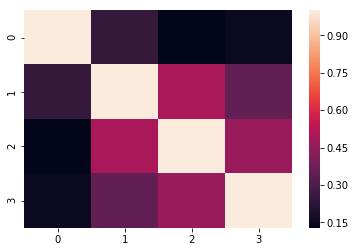

Heatmap of cohens κ between women


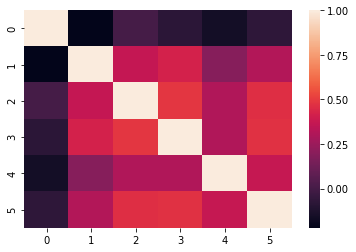

In [37]:
#Finally I print heatmaps of weighted Cohen's κ for both, men and women. Again, this is more appropriate to my
#data because the scales are ordinal. I'd be lying if I said that
#from these maps it is apparent that agreement among men is higher than among women. Indeed they seem to suggest the
#opposite. But the average Cohen's κ indeed suggests that agreement among men is higher than among women.
#We also see that there is one really bad coder among women who is likely the cuase for this. Also, there were more
#female coders than male.
print("Average  Cohen's κ for all pairs:")
print(pairwise_metric_average(cohens_weighted_kappa, anno_short.annotations))
print("Average  Cohen's κ for men:")
print(pairwise_metric_average(cohens_weighted_kappa, anno_short_men.annotations))
print("Average  Cohen's κ for women:")
print(pairwise_metric_average(cohens_weighted_kappa, anno_short_women.annotations))

m = pairwise_matrix(cohens_weighted_kappa, anno_short_men.annotations)
print("Heatmap of cohens κ between men")
ax = seaborn.heatmap(m)
plt.show()

m = pairwise_matrix(cohens_weighted_kappa, anno_short_women.annotations)
print("Heatmap of cohens κ between women")
ax = seaborn.heatmap(m)
plt.show()

In [38]:

print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


Pearson's rho among men:
0.40372599607025755
Pearson's rho among women:
0.37387186402102035


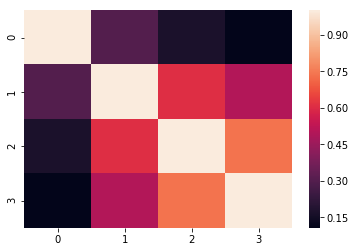

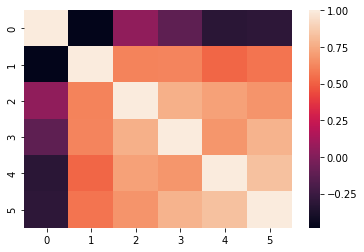

In [39]:
#Finally, given that it seems reasonable to assume that my data is metric, I turn to Pearson's rho and indeed
#this brings some brightness onto the map. Again I find that women tend to agree more from the heatmap
#but then there is one abysmal female coder. We have to ask ourselves whether this coder took his task serious.
print("Pearson's rho among men:")
print(pairwise_metric_average(pearsons_rho,anno_short_men.annotations))
print("Pearson's rho among women:")
print(pairwise_metric_average(pearsons_rho,anno_short_women.annotations))

n = pairwise_matrix(pearsons_rho, anno_short_men.annotations)
m = pairwise_matrix(pearsons_rho, anno_short_women.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

# Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides two relevant models: ModelB and ModelBt. Model B with $\theta$s models the relationship between each coder and code. Model B is a Bayesian generalization of the Dawid & Skene model from the reading. The following image schematically describes these models. <img src="../data/pyanno/Bmodel.png">

The models should provide very similar results. To estimate the parameters for any models, we first need to create a new model. 

In [40]:
# create a new instance of model B, with 4 label classes
model = ModelB.create_initial_state(4,8)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[6.27393185e-01 1.15343128e-01 2.55564313e-01 1.69937460e-03]
  [2.10211674e-01 5.70084003e-01 1.44077658e-01 7.56266657e-02]
  [1.58222353e-01 1.18503007e-01 6.45351951e-01 7.79226889e-02]
  [1.49800401e-02 5.81111839e-02 1.76232579e-01 7.50676197e-01]]

 [[7.13257638e-01 1.11738862e-01 9.97814484e-02 7.52220515e-02]
  [8.93446701e-02 7.61182137e-01 1.15419534e-01 3.40536595e-02]
  [2.70838204e-02 8.36764889e-02 6.78459075e-01 2.10780615e-01]
  [3.82522679e-04 2.27758718e-01 3.09061840e-01 4.62796920e-01]]

 [[7.66931806e-01 1.01868582e-01 6.02665325e-02 7.09330795e-02]
  [1.95415439e-01 5.43546244e-01 1.92729903e-01 6.83084148e-02]
  [4.24083929e-02 1.46288393e-01 6.69967585e-01 1.41335629e-01]
  [8.32472857e-02 7.93924225e-03 2.09802810e-01 6.99010662e-01]]

 [[7.48629080e-01 1.27747176e-01 7.41918608e-02 4.94318835e-02]
  [1.64104259e-01 6.19937062e-01 1.80314850e-01 3.56438281e-02]
  [1.28874544e-01 9.28265277e-02 6.07825455e-01 1.70473472e-01]
  [8.04437543e-03 5.61738069e-02 5

Now we train the model on our data. Pyanno allows one to use either MAP (maximum a posteriori estimation) or MLE (maximum likelihood estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator-annotation pair. First we will train with MAP, and then you can optionally training with MLE.

In [41]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [42]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.73398728e-01 2.01020245e-01 2.55810269e-02 1.20101219e-26]
  [1.47832659e-01 7.11503767e-01 7.66499157e-02 6.40136580e-02]
  [1.97431020e-02 1.48708709e-01 6.96639326e-01 1.34908863e-01]
  [2.52463780e-18 2.13647377e-02 8.51550428e-02 8.93480220e-01]]

 [[7.19395465e-01 2.01828761e-01 7.87757734e-02 1.55486964e-13]
  [1.33941799e-01 7.07223261e-01 1.10418200e-01 4.84167403e-02]
  [2.72093282e-02 1.65178369e-01 6.71232700e-01 1.36379603e-01]
  [2.15358721e-30 5.38211823e-02 1.21871740e-01 8.24307077e-01]]

 [[8.50073137e-01 1.22955501e-01 2.69713621e-02 3.64395738e-42]
  [8.93514251e-02 7.89280333e-01 8.93429608e-02 3.20252811e-02]
  [6.11638366e-02 1.29121422e-01 7.03992731e-01 1.05722011e-01]
  [6.53666390e-03 5.12606512e-02 2.10869595e-01 7.31333090e-01]]

 [[6.99612801e-01 2.70976969e-01 2.94102301e-02 8.57899704e-52]
  [9.67171336e-02 7.62615701e-01 1.09523823e-01 3.11433425e-02]
  [1.81150586e-02 1.45472330e-01 6.85587954e-01 1.50824657e-01]
  [2.71897111e-47 2.98511124e-02 2

Uncomment the cell below if you would rather train by MLE.

In [43]:
#model = ModelB.create_initial_state(4,8)
#model.mle(anno.annotations)
#print(model.theta)
#print(model.log_likelihood(anno.annotations))

Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [44]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[1.20741380e-42 1.00240780e-01 7.90821679e-01 1.08937540e-01]
 [9.92682453e-01 7.07056554e-03 2.46981317e-04 2.03944498e-49]
 [1.07420297e-03 5.51435353e-02 9.37476514e-01 6.30574822e-03]
 ...
 [8.15378491e-04 3.51193436e-02 9.59859130e-01 4.20614824e-03]
 [1.34481992e-44 2.14447325e-03 9.16166870e-01 8.16886569e-02]
 [2.14745550e-01 7.69057353e-01 1.61970966e-02 2.01807019e-26]]


Let's turn the posterior of the first 100 samples into a heatmap and compare with the raw vote tallies.

In [45]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

(<matplotlib.figure.Figure at 0x1314ee400>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1314a7828>,
  <matplotlib.axes._subplots.AxesSubplot at 0x12f1ade10>))

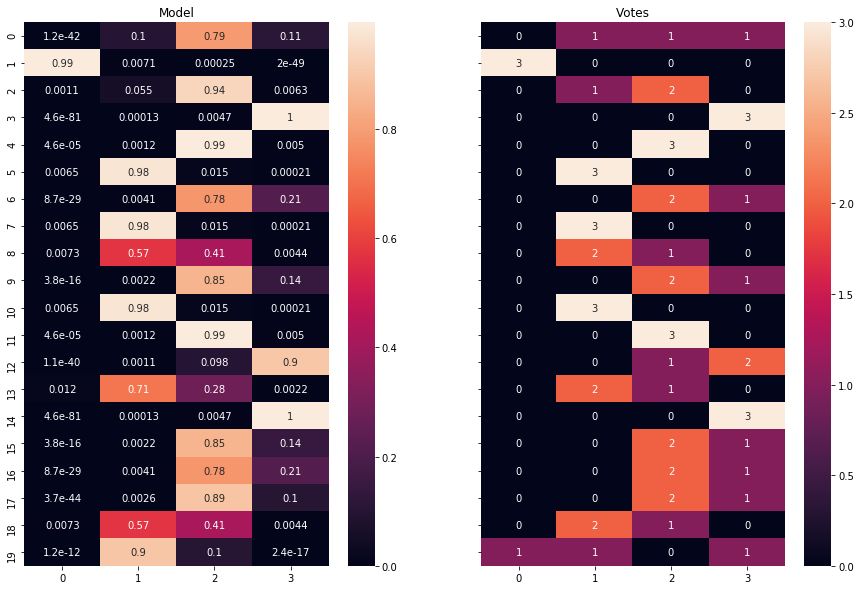

In [46]:
makeQuestionComparison(model, anno)

This differs markedly from taking annotator scores at face value. As you can see (the model-based probabilities are on left; the raw votes on right), the models helps us break ties between coders and in some cases dramatically downgrades the estimates from particularly bad coders.

Let's try everything again with ModelBt, which constrains ModelB so that each coder has a single estimate over the accuracy of all of their codes.

In [47]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.65098812 0.79563144 0.85234237 0.88161694 0.77134565 0.67128458
 0.88619925 0.75607741]
-3040.169270704677


In [48]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.79126875 0.74066409 0.76229929 0.72531347 0.71641949 0.7186128
 0.77313984 0.7166708 ]
-2811.946251119612


In [49]:
model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

array([[0.79309224, 0.77142651, 0.75148663, ..., 0.65862336, 0.76666712,
        0.70784849],
       [0.80332861, 0.7715712 , 0.74124083, ..., 0.65308169, 0.76847714,
        0.71743075],
       [0.82120235, 0.77912847, 0.72353192, ..., 0.68089015, 0.81235457,
        0.74418617],
       ...,
       [0.84025976, 0.74363362, 0.76257837, ..., 0.71238077, 0.78534657,
        0.67401994],
       [0.82857419, 0.73106866, 0.76869144, ..., 0.69493443, 0.80026794,
        0.69498225],
       [0.82857419, 0.73106866, 0.76869144, ..., 0.69493443, 0.80026794,
        0.69498225]])

In [50]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.01111085 0.28929787 0.364861   0.33473027]
 [0.99022568 0.00241836 0.00404837 0.00330759]
 [0.00250242 0.05512095 0.93454068 0.00783595]
 ...
 [0.0025319  0.04398828 0.94555154 0.00792827]
 [0.00249684 0.00571651 0.93245699 0.05932966]
 [0.03193213 0.93876315 0.01612792 0.01317679]]


Let's visualize the posterior of the first 10 samples according to ModelBt.

(<matplotlib.figure.Figure at 0x12f7acb70>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x12feca6d8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x131d55278>))

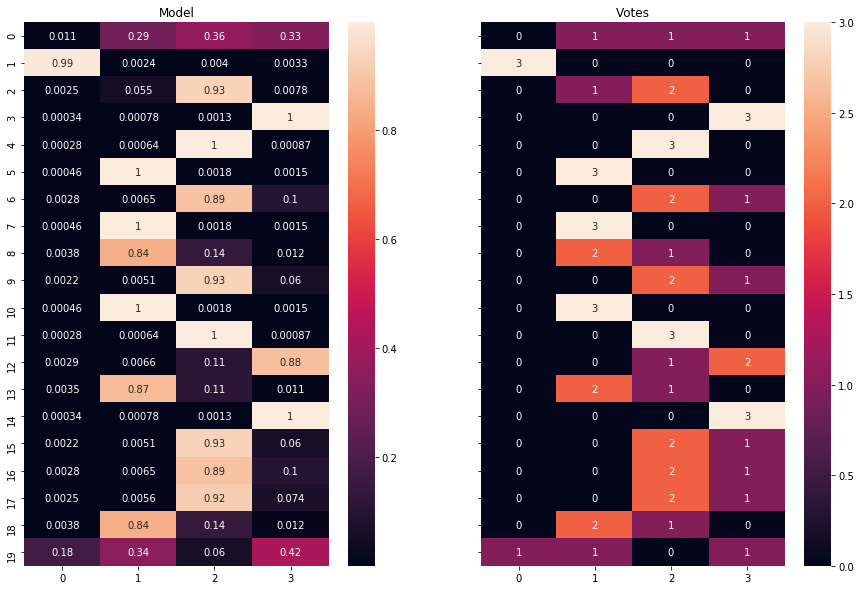

In [51]:
makeQuestionComparison(model, anno)

The property of these scores is that they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity. We may also use the posterior themselves rather than the most probably code outcome.

## Visualizing coder accuracy

Let's make a plot of the accuracy for each annotator inferred from ModelBt. This might be helpful if you wanted to ban a "troll" from your crowdsourcing enterprise. The coder a very low accuracy likelihood is an outlier and should be "dropped from the team."

In [52]:
model = ModelBt.create_initial_state(4,8)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

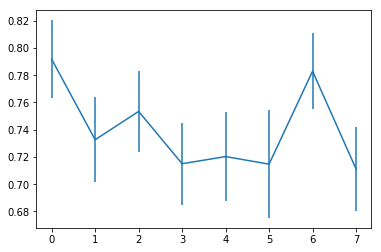

In [53]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()

# Hotel Reviews

If we want to do a simpler analysis we can look at a different data set, here are some hotel reviews from [expedia](https://www.kaggle.com/c/expedia-hotel-recommendations)

In [54]:
df_hotels = pandas.read_csv('../data/hot_Reviews.csv', index_col=0)
df_hotels[:5]

,Karen,Scott,Jessica,write a review,A verified traveler,Kevin,William,R,S,Christopher,...,Thomas,Susan,A Traveler,M,Not Provided,B,Laura,xxxxxxxxxxxxxx,Michael,Joseph
1785 Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900 House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bed & Breakfast In Cambridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Swallow's Nest Motel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abbeville Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here a rank of 0 is a missing value and to simplify things more we will convert from a 1-10 scale to a 1-5 scale, with 0 as missing

In [55]:
df_hotels = df_hotels.apply(lambda x: x // 2) #integer divide by 2 rounds all values

And we can visualize all the reviews as a heatmap with the missing values greyed out

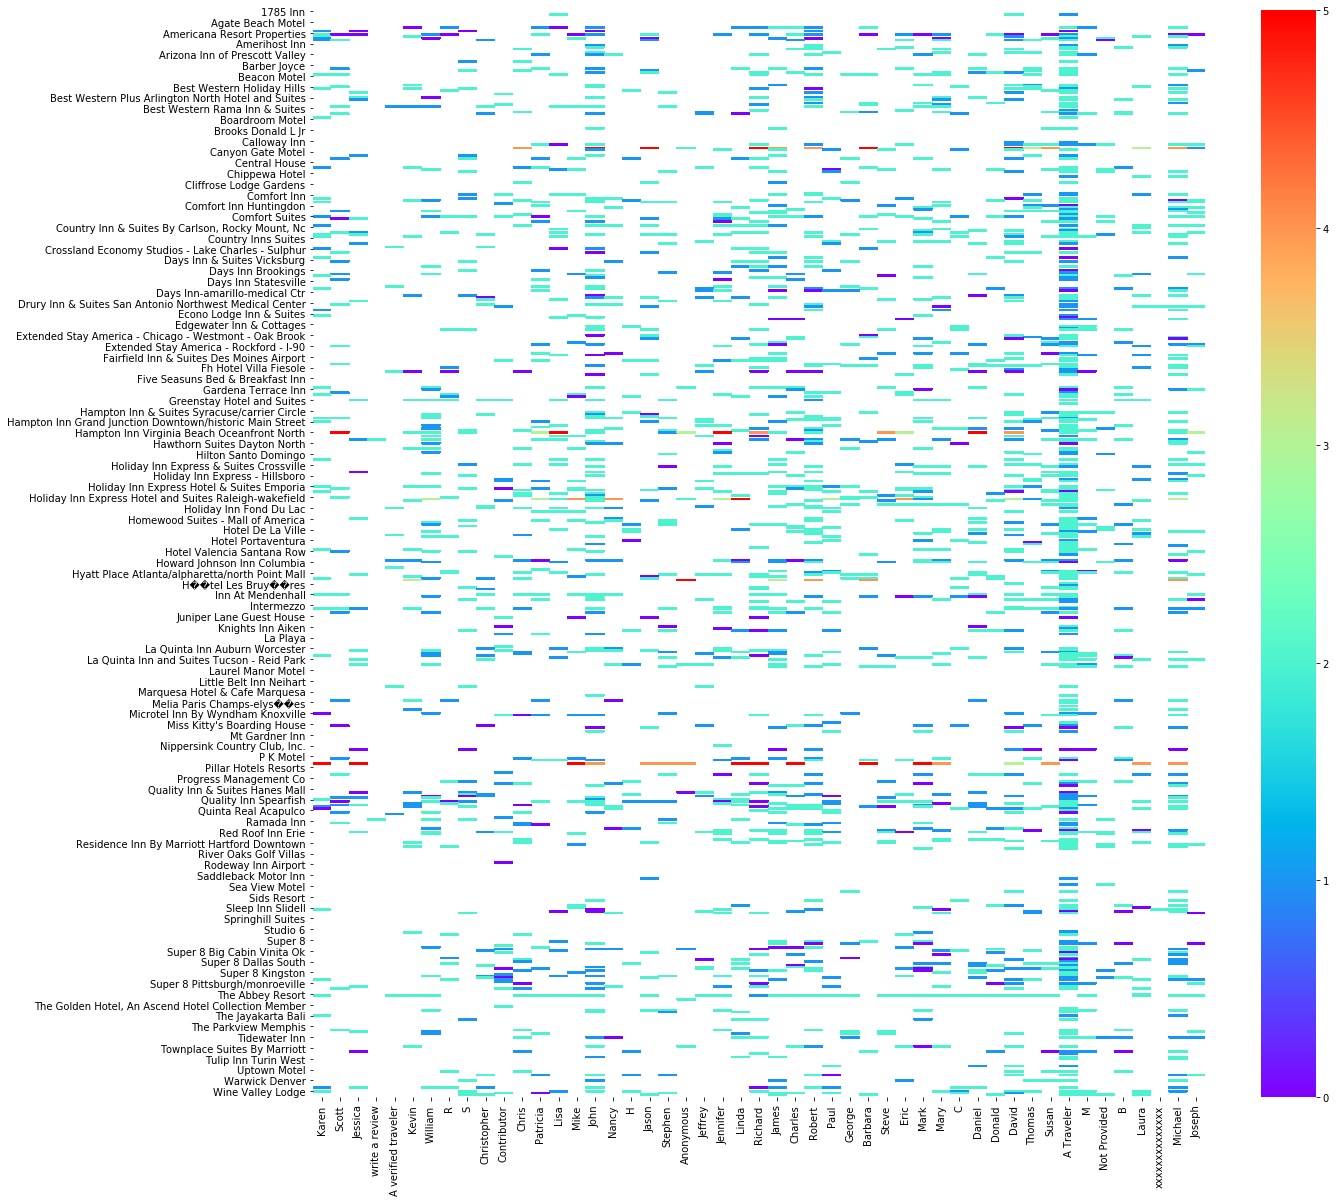

In [56]:
fig, ax = plt.subplots(figsize = (20,20))
seaborn.heatmap(df_hotels, cmap='rainbow', ax = ax)
plt.show()

To give the dataframe to pyanno we need to convert to np array and change the nans to intergers, lets use -1

In [57]:
hot_mat = np.array(df_hotels.fillna(-1).as_matrix())
anno_hot = AnnotationsContainer.from_array(hot_mat, missing_values=[-1])

In [58]:
anno_hot.annotations

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [59]:
anno_hot.labels

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

In [60]:
anno_hot.missing_values

[-1]

Look at coder agreement

In [61]:
pyanno.measures.agreement.labels_frequency(anno_hot.annotations, 6)#6 possible catagories

array([0.07806534, 0.26262198, 0.63555367, 0.00636402, 0.0093339 ,
       0.00806109])

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


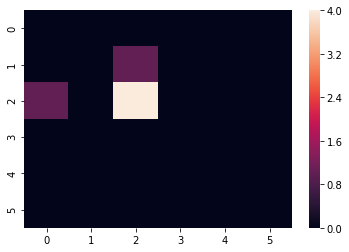

In [62]:
c = pyanno.measures.agreement.confusion_matrix(anno_hot.annotations[:,0], anno_hot.annotations[:,1], 6) #6 possible catagories
print(c)
ac = seaborn.heatmap(c)
plt.show()

Most agreement is on 2 i.e. an average hotel and there's little agreement as rating go higher, likely due to scarcity in the sample

In [63]:
scotts_pi(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.3787878787878787

In [64]:
krippendorffs_alpha(anno_hot.annotations[::])

0.398760907615921

In [65]:
cohens_kappa(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.40328336902212697

/Users/Oscar/anaconda3/lib/python3.6/site-packages/pyanno/measures/helpers.py:166: RuntimeWarning: invalid value encountered in double_scalars
  return (observed_agreement - chance_agreement) / (1. - chance_agreement)


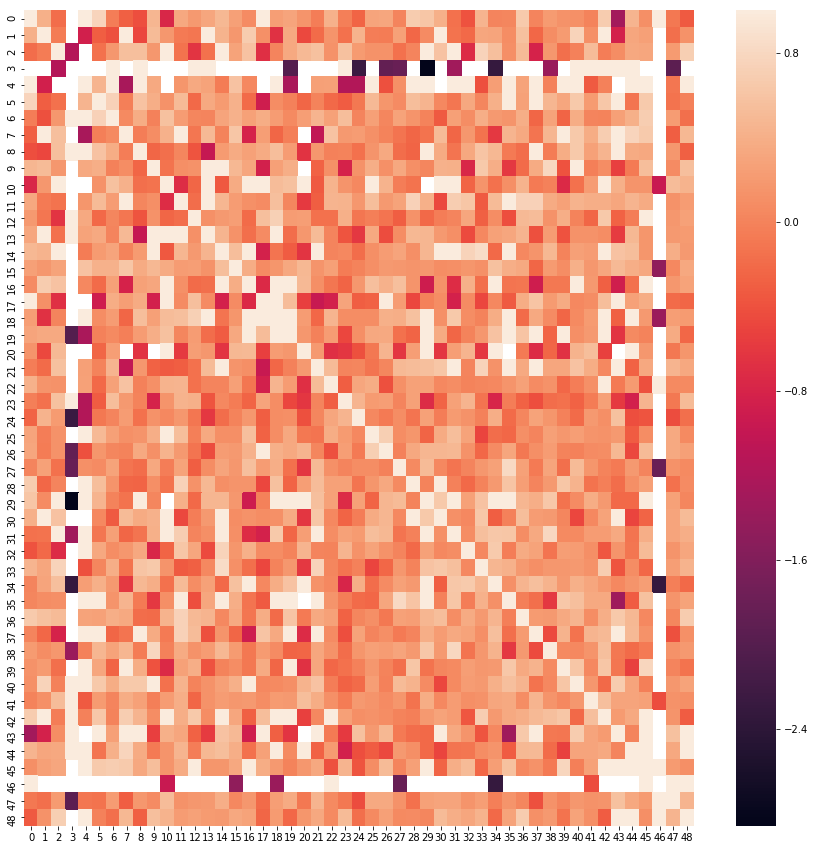

In [66]:
m = pairwise_matrix(cohens_kappa, anno_hot.annotations)
fig, ax = plt.subplots(figsize = (15, 15))
seaborn.heatmap(m, ax =ax)

And to look at what model Bt thinkgs the correct reviews are:

In [67]:
model_hot = ModelBt.create_initial_state(6, 49)
model_hot.mle(anno_hot.annotations)
#print(model.theta)
print(model_hot.log_likelihood(anno_hot.annotations))

-2697.144997487702


In [68]:
#makeQuestionComparison(anno_short, anno_hot)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MLE or MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

In [69]:
#As we saw in the heatmaps in Exercise 2: some coders suck. Or to formulate more selfcritically: I posed my question
#in a way that led some coders astray. And so it makes a lot of sense to downweight these coders.

# Set nclasses and number of annotations
model = ModelB.create_initial_state(10,10)
#First, I will train my model with a maximum a posteriori approach:
samples = model.sample_posterior_over_accuracy(anno_short.annotations, 200, burn_in_samples=100, thin_samples=3)
model.map(anno_short.annotations)
#And present the posterior distribution over the true label classes:
posterior = model.infer_labels(anno_short.annotations)
print(posterior)

[[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  7.74605490e-046 9.99884301e-001 1.15699321e-004 1.35003439e-101
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 1.04738504e-085 1.00000000e+000
  2.42762071e-101 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  1.00000000e+000 4.79589170e-074 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 1.84253518e-006 9.99998157e-001
  2.05613456e-083 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 1.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000

/Users/Oscar/anaconda3/lib/python3.6/site-packages/pyanno/util.py:80: RuntimeWarning: divide by zero encountered in log
  log_theta = ninf_to_num(log(theta))


(<matplotlib.figure.Figure at 0x12f6bf208>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x12f6bf4a8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1311bb3c8>))

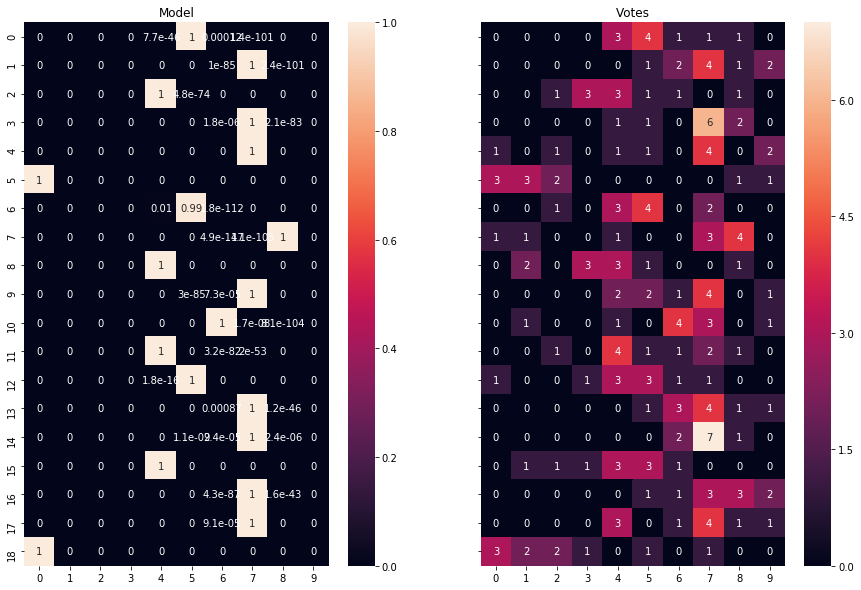

In [71]:
#And because that list of numbers doesn't tell us very much, here is a vizualization. Conveniently, I can use your 
#function because num_questions is set to 20 which is also my number it items.
#the columns suggest that some coders are notoriously "worse" than the others.
makeQuestionComparison(model, anno_short)

(<matplotlib.figure.Figure at 0x13110f710>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1333e9e48>,
  <matplotlib.axes._subplots.AxesSubplot at 0x12ee699b0>))

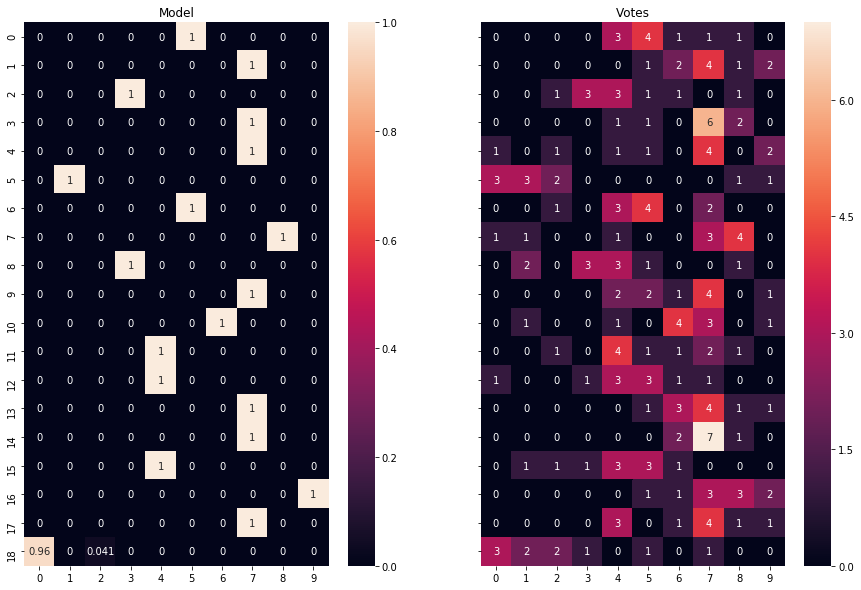

In [73]:
#Using maximum the maximum likelihood approach leads to almost identical results.
model = ModelB.create_initial_state(10,10)
model.mle(anno_short.annotations)
posterior = model.infer_labels(anno_short.annotations)
makeQuestionComparison(model, anno_short)

(<matplotlib.figure.Figure at 0x13122e4a8>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x12fbb0dd8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x130b456d8>))

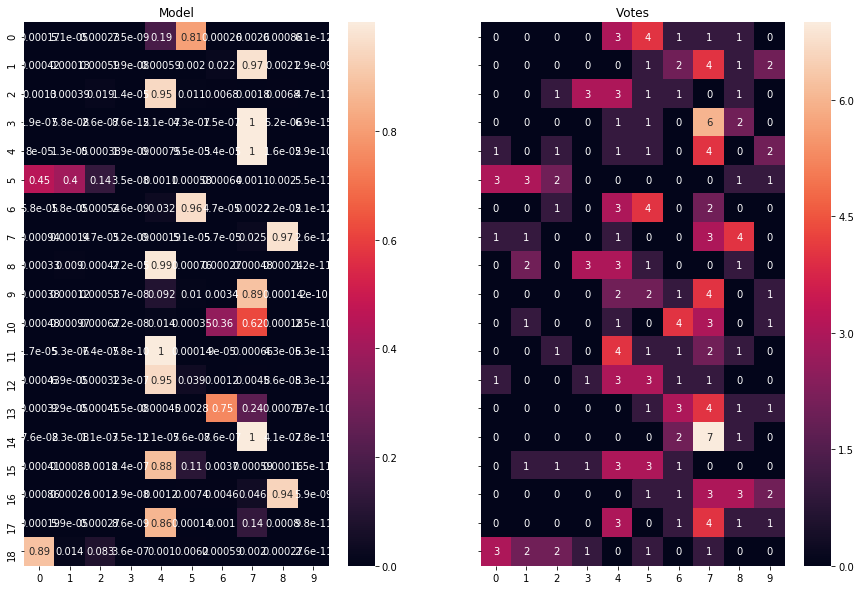

In [74]:
#Next, I apply the Bt model so that each coder has an accuracy estimate over the total of his codes.
#Again, the results are structurally very similar.
model = ModelBt.create_initial_state(10, 10)
model.map(anno_short.annotations)
posterior = model.infer_labels(anno_short.annotations)
makeQuestionComparison(model, anno_short)

In [76]:
#What we can already see from the matrices above is that some coders are usually better than others.
#To visualize this more properly, I run a last mle model and plot the accuracy likelihood.
#We see that there are indeed some outliers (coders 0 and 1 as well as 6). Given the very largy variance in coder
#accuracy, the MLE and MAP estimates differ strongly from what we would get based on a majority vote.

#The fact that some coders deviated a lot from the rest could be due to them taking the survey not very seriously. 
#When looking at the completion time on mTurk, I noticed that some coder took a lot shorter time than the others. 
#So this seems plausible. On the other hand, as was indicated above, I probably could have done a better job in 
#wording the question and it is likely that some of the coders misread my question.
model = ModelBt.create_initial_state(10,10)
model.mle(anno_short.annotations)
samples = model.sample_posterior_over_accuracy(anno_short.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

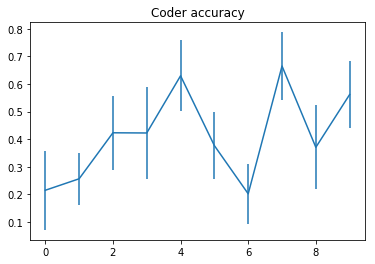

In [77]:
plt.figure()
plt.title("Coder accuracy")
plt.errorbar(range(10),y, yerr = y_ci)
plt.show()

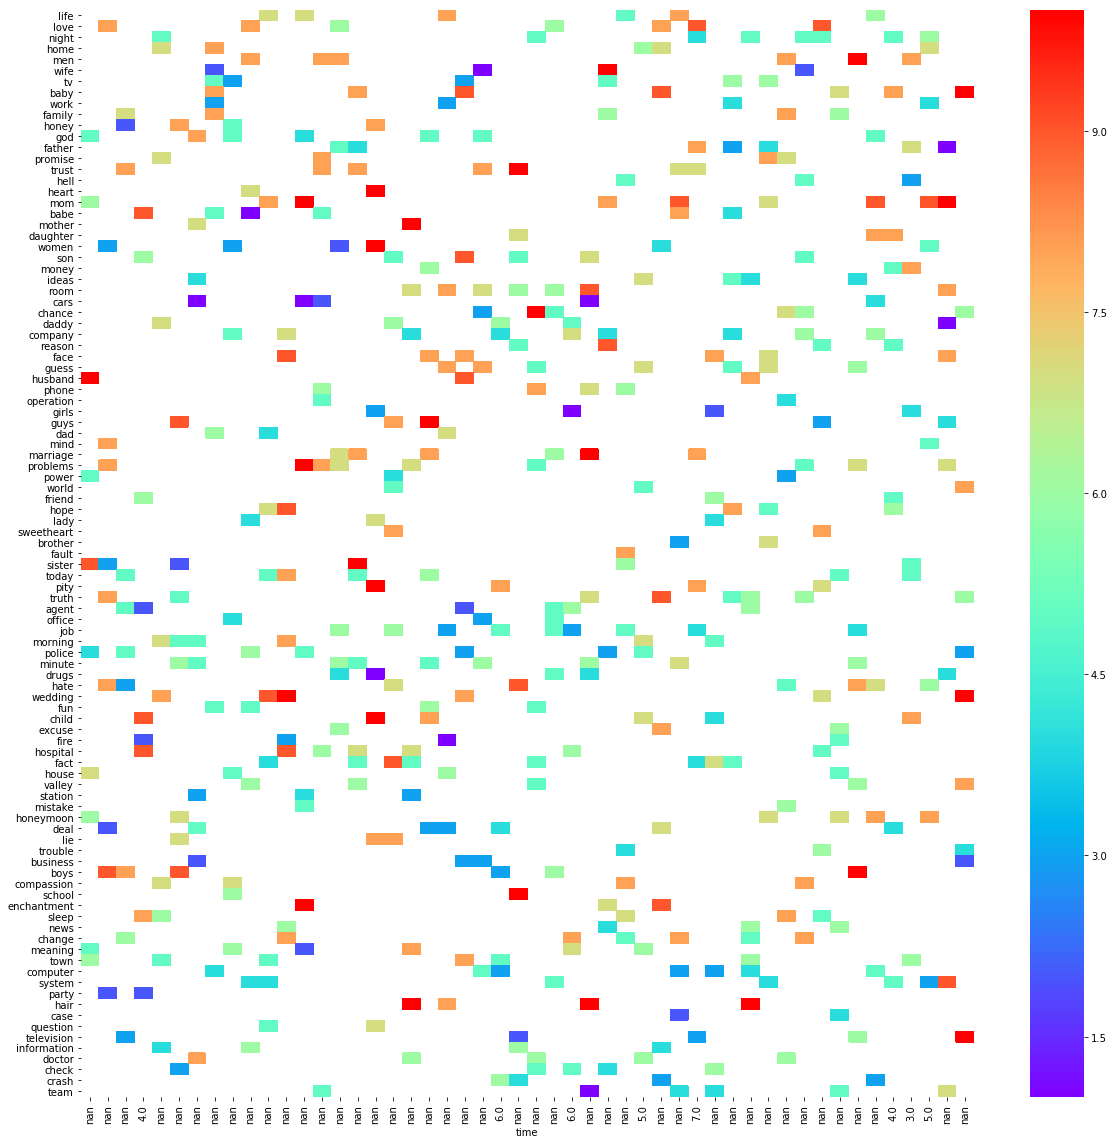

In [78]:
#On a side not, I also conducted a second survey where I extracted the 100 most frequent nouns from the soap opera
#corpus and each of 50 coders was asked to code a random sample of 10 of these words. Below you can see the results.
#While there is quite some ambiguity, we can see that certain words are coded quite stable. "Hair," or "wedding" are
#things that people think women talk about while "cars," "deals," and "business" are rather male.
long_survey = pandas.read_csv('../data/survey/Long_survey_modified_2.csv', index_col=0, delimiter = ";")
long_survey = pandas.DataFrame.transpose(long_survey)

fig, ax = plt.subplots(figsize = (20,20))
seaborn.heatmap(long_survey, cmap='rainbow', ax = ax)
plt.show()